<a href="https://colab.research.google.com/github/colingwuyu/hedgingbox/blob/master/examples/dqn/dqn_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install necessary dependencies.
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]
!pip install dm-acme[envs]


     |████████████████████████████████| 133kB 9.2MB/s 
  Created wheel for dm-acme: filename=dm_acme-0.1.8-cp36-none-any.whl size=265910 sha256=f4c77a8808c7ccd783acf2768630f3b2175a6e011e6cc1b0d206de3caa3d79f1
  Stored in directory: /root/.cache/pip/wheels/3d/b4/b7/e41339537d9433921ff26e8f9827b48052366c5125434825d7
Successfully built dm-acme
     |████████████████████████████████| 6.1MB 23kB/s 
     |████████████████████████████████| 322.8MB 48kB/s 
     |████████████████████████████████| 460kB 55.9MB/s 
     |████████████████████████████████| 6.8MB 23.1MB/s 
     |████████████████████████████████| 4.3MB 9.1MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 256kB 54.1MB/s 
  Cloning git://github.com/deepmind/bsuite.git to /tmp/pip-install-qbum3_px/bsuite
  Running command git clone -q git://github.com/deepmind/bsuite.git /tmp/pip-install-qbum3_px/bsuite
     |████████████████████████████████| 18.6MB 162kB/s 
     |██████████████████████

In [4]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
#@title Update HedgingBox
import os
project_folder = '/content/Projects'
hb_source = os.path.join(project_folder, 'HedgingBox')
%mkdir "$project_folder"
%cd "$project_folder"
!pwd
!mkdir -p 'ACME Models/QTable'
!git clone https://github.com/colingwuyu/HedgingBox.git
%cd HedgingBox
!git fetch --all
!git checkout -b develop origin/develop 
!git pull
import sys
sys.path.append(hb_source)

mkdir: cannot create directory ‘/content/Projects’: File exists
/content/Projects
/content/Projects
fatal: destination path 'HedgingBox' already exists and is not an empty directory.
/content/Projects/HedgingBox
Fetching origin
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/colingwuyu/HedgingBox
   5a62996..5c20ebe  develop    -> origin/develop
fatal: A branch named 'develop' already exists.
Updating 5a62996..5c20ebe
Fast-forward
 hb/core.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [2]:
#@title Import Modules
import acme
import dm_env
from acme import specs
from acme import datasets
from acme import wrappers
from acme.utils.loggers.csv import CSVLogger
from acme.adders import reverb as adders
from acme.tf import savers as tf2_savers
from acme.tf import networks as tf2_netwroks

import sonnet as snt

import reverb
import trfl

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import hb
from hb.market_env import hedging_market_env
from hb.market_env.pathgenerators import gbm_pathgenerator
from hb.market_env.rewardrules.pnl_reward import PnLReward
from hb.market_env.rewardrules.pnl_qmeasure_reward import PnLQMeasureReward
from hb.market_env.rewardrules.pnl_sqrpenalty_reward import PnLSquarePenaltyReward
from hb.market_env import market_specs
from hb.bots.dqnbot import bot
from hb.bots.deltabot.bot import DeltaHedgeBot
from hb.pricing import blackscholes

from absl import flags

In [12]:
#@title Training Environment Setup
trading_cost_pct =  0.001#@param {type:"number"}
kappa =  1.0#@param {type:"number"}
initial_price =  50#@param {type:"number"}
drift = 0.1 #@param {type:"number"}
sigma = 0.3 #@param {type:"number"}
number_steps =  90#@param {type:"integer"}
stock_price_lower_bound = 1 #@param {type:"integer"}
stock_price_upper_bound = 10000 #@param {type:"integer"}
lot_size = 1 #@param {type:"integer"}
stock_ticker_size = 1 #@param {type:"integer"}
option_holding =  -10#@param {type:"integer"}
initial_stock_holding =  5#@param {type:"integer"}
buy_sell_lots_bound =  4#@param {type:"integer"}
risk_free_rate = 0.02 #@param {type:"number"}
step_size = 1 #@param {type:"integer"}

step_size = step_size/360.
option_maturity = number_steps*step_size
atm_strike = initial_price*np.exp(risk_free_rate*option_maturity)
initial_option_price = blackscholes.price(True, initial_price, risk_free_rate,
                                          0., atm_strike, sigma, option_maturity,
                                          option_maturity)
gbm = gbm_pathgenerator.GBMGenerator(
            initial_price=initial_price, drift=drift,
            div=0.0, sigma=sigma, num_step=number_steps, 
            step_size=step_size, seed=1234
        )
gbm_pred = gbm_pathgenerator.GBMGenerator(
            initial_price=initial_price, drift=drift,
            div=0.0, sigma=sigma, num_step=number_steps, 
            step_size=step_size, seed=4321
        )
pnl_penalty_reward = PnLSquarePenaltyReward(scale_k=kappa)
pnl_qmeasure_reward = PnLQMeasureReward(scale_k=kappa)
pnl_reward = PnLReward()
market_param = market_specs.MarketEnvParam(
    stock_ticker_size=stock_ticker_size,
    stock_price_lower_bound=stock_price_lower_bound,
    stock_price_upper_bound=stock_price_upper_bound,
    lot_size=lot_size,
    buy_sell_lots_bound=buy_sell_lots_bound,
    holding_lots_bound=np.infty)
environment = wrappers.SinglePrecisionWrapper(hedging_market_env.HedgingMarketEnv(
            stock_generator=gbm,
            reward_rule=pnl_penalty_reward,
            market_param=market_param,
            trading_cost_pct=trading_cost_pct,
            risk_free_rate=risk_free_rate,
            discount_rate=0.,
            option_maturity=option_maturity,
            option_strike=atm_strike,
            option_holding=option_holding,
            initial_stock_holding=initial_stock_holding,
        ))


In [14]:
#@title Create DQN Hedging Bot
#@markdown ###Replay Buffer Param
batch_size =  256#@param {type:"integer"}
samples_per_insert =  32#@param {type:"integer"}
#@markdown ###Prediction Param
num_prediction_episodes =  1000#@param {type:"integer"}
train_episodes_per_pred =  5000#@param {type:"integer"}
model_name = "01tc_5h_10drift_2r_30sig_duelling_moneyness_kappa1" #@param {type:"string"}
create_new_model = False #@param {type:"boolean"}
flags.FLAGS.acme_id = 'DQN/'+model_name
model_path = f"/content/gdrive/My Drive/Projects/ACME Models/DQN/{model_name}/"
if not os.path.exists(model_path):
  os.makedirs(model_path)
model_chkpt = model_path + "checkpoint" 
if not os.path.exists(model_chkpt):
  os.makedirs(model_chkpt)
dqn_bot_env_attr = ['remaining_time', 'stock_holding', 'stock_price', 'option_price', 'moneyness']
environment.set_obs_attr(dqn_bot_env_attr)
spec = specs.make_environment_spec(environment)
network = tf2_netwroks.DuellingMLP(num_actions = buy_sell_lots_bound*2+1,
                                   hidden_sizes = [200, 200])
# checkpointer = tf2_savers.Checkpointer(
#     objects_to_save={'network': network},
#     directory=model_chkpt
# )
# checkpointer.restore()
# Construct the agent.
dqn_bot = bot.DQNBot(
    environment_spec=spec,
    network=network,
    batch_size=batch_size,
    samples_per_insert=samples_per_insert,
    pred_episode=num_prediction_episodes,
    observation_per_pred=train_episodes_per_pred,
    pred_dir=model_path,
    checkpoint_subpath=model_path,
    checkpoint_per_min=30.
    )
dqn_bot._checkpointer.save(force=True)
#!cp -rf "$model_chkpt"/* "$dqn_bot._checkpointer._checkpoint_dir"/

True

In [ ]:
#@title DQN Bot Train & Prediction
dqn_bot._actor._actor._adder.reset()
environment.set_obs_attr(dqn_bot_env_attr)
num_episodes =  train_episodes_per_pred + num_prediction_episodes
num_check_points =  30#@param {type:"integer"}
learning_rate =  1e-3#@param {type:"number"}
epsilon = 0.05 #@param {type:"number"}
prediction = False #@param {type:"boolean"}
repeat_path = None

# update learning rate
dqn_bot._learner._optimizer.learning_rate = learning_rate
# update exploration epsilon
dqn_bot._actor._actor._policy_network = tf.function(
    snt.Sequential([
            dqn_bot._learner._network,
            lambda q: trfl.epsilon_greedy(q, epsilon=epsilon).sample(),
        ])
)
environment.set_repeat_path(repeat_path)
dqn_bot.set_pred_only(prediction)
if prediction:
  num_check_points = 1
# Try running the environment loop. We have no assertions here because all
# we care about is that the agent runs without raising any errors.
if num_episodes > 0:
  for i in range(num_check_points):
    print(f"Check Point {i}")
    # train
    environment.set_stock_generator(gbm)
    loop = acme.EnvironmentLoop(environment, dqn_bot)
    if not prediction:
      loop.run(num_episodes=train_episodes_per_pred)
    # prediction
    gbm_pred.restart()
    environment.set_stock_generator(gbm_pred)
    loop.run(num_episodes=num_prediction_episodes)

Check Point 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <module '__main__'> is a built-in module
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <module '__main__'> is a built-in module
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <module '__main__'> is a built-in module
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[Environment Loop] Episode Length = 90 | Episode Return = -492115.986 | Episodes = 7 | Steps = 630 | Steps Per Second = 616.951


INFO:tensorflow:Assets written to: /root/acme/d6e59afa-dde3-11ea-9816-0242ac1c0002/snapshots/network/assets


INFO:tensorflow:Assets written to: /root/acme/d6e59afa-dde3-11ea-9816-0242ac1c0002/snapshots/network/assets


Streaming output truncated to the last 5000 lines.
[Learner] Loss = 0.249 | Steps = 27626 | Walltime = 795.839
[Environment Loop] Episode Length = 90 | Episode Return = -16.142 | Episodes = 2468 | Steps = 222120 | Steps Per Second = 317.986
[Learner] Loss = 0.227 | Steps = 27667 | Walltime = 796.844
[Learner] Loss = 0.253 | Steps = 27686 | Walltime = 797.855
[Environment Loop] Episode Length = 90 | Episode Return = -66.946 | Episodes = 2472 | Steps = 222480 | Steps Per Second = 125.161
[Learner] Loss = 0.215 | Steps = 27707 | Walltime = 798.881
[Environment Loop] Episode Length = 90 | Episode Return = -15.614 | Episodes = 2474 | Steps = 222660 | Steps Per Second = 180.384
[Learner] Loss = 0.212 | Steps = 27732 | Walltime = 799.896
[Environment Loop] Episode Length = 90 | Episode Return = -25.947 | Episodes = 2477 | Steps = 222930 | Steps Per Second = 333.010
[Learner] Loss = 0.255 | Steps = 27773 | Walltime = 800.900
[Environment Loop] Episode Length = 90 | Episode Return = -94.825 | E

INFO:tensorflow:Assets written to: /root/acme/d6e59afa-dde3-11ea-9816-0242ac1c0002/snapshots/network/assets


Streaming output truncated to the last 5000 lines.
[Learner] Loss = 0.199 | Steps = 145505 | Walltime = 4361.695
[Environment Loop] Episode Length = 90 | Episode Return = -29.892 | Episodes = 2945 | Steps = 265050 | Steps Per Second = 348.492
[Learner] Loss = 0.175 | Steps = 145546 | Walltime = 4362.705
[Environment Loop] Episode Length = 90 | Episode Return = -136.884 | Episodes = 2949 | Steps = 265410 | Steps Per Second = 342.204
[Learner] Loss = 0.209 | Steps = 145588 | Walltime = 4363.723
[Environment Loop] Episode Length = 90 | Episode Return = -26.311 | Episodes = 2953 | Steps = 265770 | Steps Per Second = 314.611
[Learner] Loss = 0.215 | Steps = 145624 | Walltime = 4364.754
[Environment Loop] Episode Length = 90 | Episode Return = -27.589 | Episodes = 2956 | Steps = 266040 | Steps Per Second = 151.617
[Learner] Loss = 0.242 | Steps = 145643 | Walltime = 4365.764
[Environment Loop] Episode Length = 90 | Episode Return = -27.923 | Episodes = 2958 | Steps = 266220 | Steps Per Secon

INFO:tensorflow:Assets written to: /root/acme/d6e59afa-dde3-11ea-9816-0242ac1c0002/snapshots/network/assets


Streaming output truncated to the last 5000 lines.
[Learner] Loss = 0.220 | Steps = 258549 | Walltime = 7938.578
[Environment Loop] Episode Length = 90 | Episode Return = -19.415 | Episodes = 2994 | Steps = 269460 | Steps Per Second = 288.870
[Learner] Loss = 0.240 | Steps = 258586 | Walltime = 7939.579
[Environment Loop] Episode Length = 90 | Episode Return = -21.896 | Episodes = 2998 | Steps = 269820 | Steps Per Second = 303.887
[Learner] Loss = 0.242 | Steps = 258624 | Walltime = 7940.589
[Environment Loop] Episode Length = 90 | Episode Return = -8.073 | Episodes = 3002 | Steps = 270180 | Steps Per Second = 314.729
[Learner] Loss = 0.243 | Steps = 258662 | Walltime = 7941.600
[Environment Loop] Episode Length = 90 | Episode Return = -18.574 | Episodes = 3006 | Steps = 270540 | Steps Per Second = 339.746
[Learner] Loss = 0.208 | Steps = 258696 | Walltime = 7942.619
[Learner] Loss = 0.247 | Steps = 258715 | Walltime = 7943.667
[Environment Loop] Episode Length = 90 | Episode Return = 

INFO:tensorflow:Assets written to: /root/acme/d6e59afa-dde3-11ea-9816-0242ac1c0002/snapshots/network/assets


Streaming output truncated to the last 5000 lines.
[Environment Loop] Episode Length = 90 | Episode Return = -38.722 | Episodes = 2944 | Steps = 264960 | Steps Per Second = 282.922
[Learner] Loss = 0.217 | Steps = 370512 | Walltime = 11535.602
[Environment Loop] Episode Length = 90 | Episode Return = -35.648 | Episodes = 2946 | Steps = 265140 | Steps Per Second = 127.509
[Learner] Loss = 0.266 | Steps = 370527 | Walltime = 11536.637
[Environment Loop] Episode Length = 90 | Episode Return = -8.579 | Episodes = 2948 | Steps = 265320 | Steps Per Second = 141.056
[Learner] Loss = 0.213 | Steps = 370545 | Walltime = 11537.717
[Environment Loop] Episode Length = 90 | Episode Return = -14.358 | Episodes = 2951 | Steps = 265590 | Steps Per Second = 294.624
[Learner] Loss = 0.194 | Steps = 370581 | Walltime = 11538.735
[Environment Loop] Episode Length = 90 | Episode Return = -92.433 | Episodes = 2955 | Steps = 265950 | Steps Per Second = 322.732
[Learner] Loss = 0.226 | Steps = 370621 | Wallti

INFO:tensorflow:Assets written to: /root/acme/d6e59afa-dde3-11ea-9816-0242ac1c0002/snapshots/network/assets


Streaming output truncated to the last 5000 lines.
[Environment Loop] Episode Length = 90 | Episode Return = -16.725 | Episodes = 2805 | Steps = 252450 | Steps Per Second = 302.908
[Learner] Loss = 0.228 | Steps = 481463 | Walltime = 15118.349
[Environment Loop] Episode Length = 90 | Episode Return = -28.010 | Episodes = 2809 | Steps = 252810 | Steps Per Second = 293.195
[Learner] Loss = 0.199 | Steps = 481502 | Walltime = 15119.380
[Environment Loop] Episode Length = 90 | Episode Return = -28.492 | Episodes = 2813 | Steps = 253170 | Steps Per Second = 294.942
[Learner] Loss = 0.228 | Steps = 481532 | Walltime = 15120.398
[Environment Loop] Episode Length = 90 | Episode Return = -39.224 | Episodes = 2815 | Steps = 253350 | Steps Per Second = 133.645
[Learner] Loss = 0.211 | Steps = 481548 | Walltime = 15121.410
[Environment Loop] Episode Length = 90 | Episode Return = -12.634 | Episodes = 2817 | Steps = 253530 | Steps Per Second = 181.475
[Learner] Loss = 0.192 | Steps = 481569 | Wallt

INFO:tensorflow:Assets written to: /root/acme/d6e59afa-dde3-11ea-9816-0242ac1c0002/snapshots/network/assets


Streaming output truncated to the last 5000 lines.
[Environment Loop] Episode Length = 90 | Episode Return = -17.511 | Episodes = 2588 | Steps = 232920 | Steps Per Second = 292.580
[Learner] Loss = 0.199 | Steps = 591493 | Walltime = 18727.840
[Learner] Loss = 0.220 | Steps = 591529 | Walltime = 18728.885
[Environment Loop] Episode Length = 90 | Episode Return = -80.005 | Episodes = 2592 | Steps = 233280 | Steps Per Second = 140.291
[Learner] Loss = 0.232 | Steps = 591547 | Walltime = 18729.917
[Environment Loop] Episode Length = 90 | Episode Return = -51.416 | Episodes = 2594 | Steps = 233460 | Steps Per Second = 153.262
[Learner] Loss = 0.207 | Steps = 591569 | Walltime = 18730.933
[Environment Loop] Episode Length = 90 | Episode Return = -7.365 | Episodes = 2596 | Steps = 233640 | Steps Per Second = 136.608
[Learner] Loss = 0.242 | Steps = 591590 | Walltime = 18731.950
[Learner] Loss = 0.201 | Steps = 591626 | Walltime = 18732.959
[Environment Loop] Episode Length = 90 | Episode Ret

INFO:tensorflow:Assets written to: /root/acme/d6e59afa-dde3-11ea-9816-0242ac1c0002/snapshots/network/assets


Streaming output truncated to the last 5000 lines.
[Environment Loop] Episode Length = 90 | Episode Return = -27.639 | Episodes = 2418 | Steps = 217620 | Steps Per Second = 161.217
[Learner] Loss = 0.241 | Steps = 702083 | Walltime = 22329.041
[Environment Loop] Episode Length = 90 | Episode Return = -33.193 | Episodes = 2421 | Steps = 217890 | Steps Per Second = 325.459
[Learner] Loss = 0.219 | Steps = 702114 | Walltime = 22330.046
[Learner] Loss = 0.255 | Steps = 702152 | Walltime = 22331.057
[Environment Loop] Episode Length = 90 | Episode Return = -5.273 | Episodes = 2425 | Steps = 218250 | Steps Per Second = 344.842
[Learner] Loss = 0.177 | Steps = 702191 | Walltime = 22332.060
[Environment Loop] Episode Length = 90 | Episode Return = -16.105 | Episodes = 2429 | Steps = 218610 | Steps Per Second = 306.994
[Learner] Loss = 0.252 | Steps = 702229 | Walltime = 22333.067
[Environment Loop] Episode Length = 90 | Episode Return = -74.967 | Episodes = 2433 | Steps = 218970 | Steps Per Se

INFO:tensorflow:Assets written to: /root/acme/d6e59afa-dde3-11ea-9816-0242ac1c0002/snapshots/network/assets


Streaming output truncated to the last 5000 lines.
[Learner] Loss = 0.183 | Steps = 812450 | Walltime = 25926.883
[Environment Loop] Episode Length = 90 | Episode Return = -21.333 | Episodes = 2229 | Steps = 200610 | Steps Per Second = 300.630
[Learner] Loss = 0.257 | Steps = 812488 | Walltime = 25927.903
[Environment Loop] Episode Length = 90 | Episode Return = -49.100 | Episodes = 2233 | Steps = 200970 | Steps Per Second = 313.953
[Learner] Loss = 0.214 | Steps = 812525 | Walltime = 25928.918
[Environment Loop] Episode Length = 90 | Episode Return = -71.003 | Episodes = 2237 | Steps = 201330 | Steps Per Second = 338.102
[Learner] Loss = 0.153 | Steps = 812554 | Walltime = 25930.092
[Environment Loop] Episode Length = 90 | Episode Return = -22.734 | Episodes = 2239 | Steps = 201510 | Steps Per Second = 123.194
[Learner] Loss = 0.224 | Steps = 812570 | Walltime = 25931.121
[Learner] Loss = 0.242 | Steps = 812586 | Walltime = 25932.156
[Environment Loop] Episode Length = 90 | Episode Re

INFO:tensorflow:Assets written to: /root/acme/d6e59afa-dde3-11ea-9816-0242ac1c0002/snapshots/network/assets


Streaming output truncated to the last 5000 lines.
[Learner] Loss = 0.182 | Steps = 924422 | Walltime = 29556.818
[Environment Loop] Episode Length = 90 | Episode Return = -5.367 | Episodes = 2184 | Steps = 196560 | Steps Per Second = 290.503
[Learner] Loss = 0.209 | Steps = 924460 | Walltime = 29557.844
[Environment Loop] Episode Length = 90 | Episode Return = -32.380 | Episodes = 2188 | Steps = 196920 | Steps Per Second = 271.788
[Learner] Loss = 0.223 | Steps = 924498 | Walltime = 29558.885
[Learner] Loss = 0.219 | Steps = 924532 | Walltime = 29559.901
[Environment Loop] Episode Length = 90 | Episode Return = -38.072 | Episodes = 2192 | Steps = 197280 | Steps Per Second = 251.542
[Learner] Loss = 0.246 | Steps = 924563 | Walltime = 29560.904
[Environment Loop] Episode Length = 90 | Episode Return = -18.019 | Episodes = 2195 | Steps = 197550 | Steps Per Second = 238.967
[Learner] Loss = 0.217 | Steps = 924593 | Walltime = 29561.934
[Environment Loop] Episode Length = 90 | Episode Ret

INFO:tensorflow:Assets written to: /root/acme/d6e59afa-dde3-11ea-9816-0242ac1c0002/snapshots/network/assets


Streaming output truncated to the last 5000 lines.
[Environment Loop] Episode Length = 90 | Episode Return = -28.296 | Episodes = 2163 | Steps = 194670 | Steps Per Second = 296.674
[Learner] Loss = 0.206 | Steps = 1036726 | Walltime = 33176.946
[Environment Loop] Episode Length = 90 | Episode Return = -17.844 | Episodes = 2167 | Steps = 195030 | Steps Per Second = 296.549
[Learner] Loss = 0.213 | Steps = 1036763 | Walltime = 33177.950
[Environment Loop] Episode Length = 90 | Episode Return = -35.842 | Episodes = 2171 | Steps = 195390 | Steps Per Second = 277.258
[Learner] Loss = 0.190 | Steps = 1036800 | Walltime = 33178.967
[Learner] Loss = 0.213 | Steps = 1036839 | Walltime = 33179.978
[Environment Loop] Episode Length = 90 | Episode Return = -15.332 | Episodes = 2175 | Steps = 195750 | Steps Per Second = 284.414
[Learner] Loss = 0.230 | Steps = 1036875 | Walltime = 33180.983
[Environment Loop] Episode Length = 90 | Episode Return = -41.942 | Episodes = 2179 | Steps = 196110 | Steps 

INFO:tensorflow:Assets written to: /root/acme/d6e59afa-dde3-11ea-9816-0242ac1c0002/snapshots/network/assets


[Learner] Loss = 0.199 | Steps = 1124876 | Walltime = 36060.126
Check Point 20
[Learner] Loss = 0.220 | Steps = 1124912 | Walltime = 36061.238
[Environment Loop] Episode Length = 90 | Episode Return = -38.647 | Episodes = 4 | Steps = 360 | Steps Per Second = 287.888
[Learner] Loss = 0.243 | Steps = 1124950 | Walltime = 36062.263
[Environment Loop] Episode Length = 90 | Episode Return = -59.012 | Episodes = 8 | Steps = 720 | Steps Per Second = 288.640
[Learner] Loss = 0.236 | Steps = 1124988 | Walltime = 36063.274
[Environment Loop] Episode Length = 90 | Episode Return = -9.961 | Episodes = 12 | Steps = 1080 | Steps Per Second = 300.382
[Learner] Loss = 0.235 | Steps = 1125027 | Walltime = 36064.301
[Environment Loop] Episode Length = 90 | Episode Return = -30.314 | Episodes = 16 | Steps = 1440 | Steps Per Second = 303.672
[Learner] Loss = 0.227 | Steps = 1125066 | Walltime = 36065.306
[Environment Loop] Episode Length = 90 | Episode Return = -66.244 | Episodes = 20 | Steps = 1800 | Ste

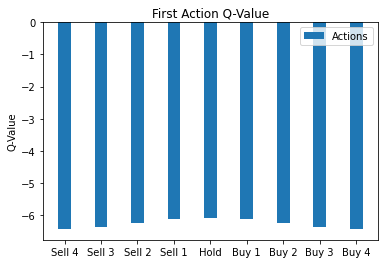

In [9]:
#@title First Action Q-Value
import tensorflow as tf
from acme.tf import utils as tf2_utils
observation = np.array([number_steps*step_size*360.,initial_stock_holding,
                        initial_price,initial_option_price, 1.0],dtype=np.float32)
batched_obs = tf2_utils.add_batch_dim(observation)

# Forward the policy network.
firstaction_q = dqn_bot._learner._network(batched_obs)[0]
labels = ['Sell 4', 'Sell 3', 'Sell 2', 'Sell 1', 'Hold', 'Buy 1', 'Buy 2', 'Buy 3', 'Buy 4']
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
fah = ax.bar(x, firstaction_q, width, label='Actions')

ax.set_ylabel('Q-Value')
ax.set_title('First Action Q-Value')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()
plt.savefig(f'{model_path}firstaction.png')
plt.show()

In [10]:
#@title Delta Hedging Bot Prediction
delta_bot_env_attr = ['remaining_time', 'option_holding', 'option_strike',
                      'interest_rate', 'stock_price', 'stock_dividend',
                      'stock_sigma', 'stock_holding', 'option_price']
environment.set_obs_attr(delta_bot_env_attr)
gbm_pred.restart()
environment.set_stock_generator(gbm_pred)
spec = specs.make_environment_spec(environment)
delta_pred_logger = CSVLogger(f'{model_path}/delta_pred',
                              label='delta_pred')
if os.path.exists(delta_pred_logger.file_path):
  os.remove(delta_pred_logger.file_path)
delta_bot = DeltaHedgeBot(environment_spec=spec,
                          pred_dir = model_path)
loop = acme.EnvironmentLoop(environment, delta_bot)
loop.run(num_episodes=num_prediction_episodes)

[Environment Loop] Episode Length = 90 | Episode Return = -6.921 | Episodes = 18 | Steps = 1620 | Steps Per Second = 1695.940
[Environment Loop] Episode Length = 90 | Episode Return = -7.058 | Episodes = 33 | Steps = 2970 | Steps Per Second = 1868.185
[Environment Loop] Episode Length = 90 | Episode Return = -6.075 | Episodes = 49 | Steps = 4410 | Steps Per Second = 500.249
[Environment Loop] Episode Length = 90 | Episode Return = -23.740 | Episodes = 66 | Steps = 5940 | Steps Per Second = 484.534
[Environment Loop] Episode Length = 90 | Episode Return = -18.536 | Episodes = 84 | Steps = 7560 | Steps Per Second = 487.138
[Environment Loop] Episode Length = 90 | Episode Return = -1.537 | Episodes = 101 | Steps = 9090 | Steps Per Second = 490.401
[Environment Loop] Episode Length = 90 | Episode Return = -10.613 | Episodes = 118 | Steps = 10620 | Steps Per Second = 472.167
[Environment Loop] Episode Length = 90 | Episode Return = -23.080 | Episodes = 136 | Steps = 12240 | Steps Per Second

In [11]:
train_perf = pd.read_csv(dqn_bot._predictor._performance_logger.file_path)
delta_hedge_perf = pd.read_csv(delta_bot._predictor._performance_logger.file_path)

In [12]:
dqn_pnl_list = train_perf[train_perf.type=='pnl'].drop(['path_num','type'], axis=1).sum(axis=1).values
delta_pnl_list = delta_hedge_perf[train_perf.type=='pnl'].drop(['path_num','type'], axis=1).sum(axis=1).values
dqn_index_order = np.argsort(dqn_pnl_list)

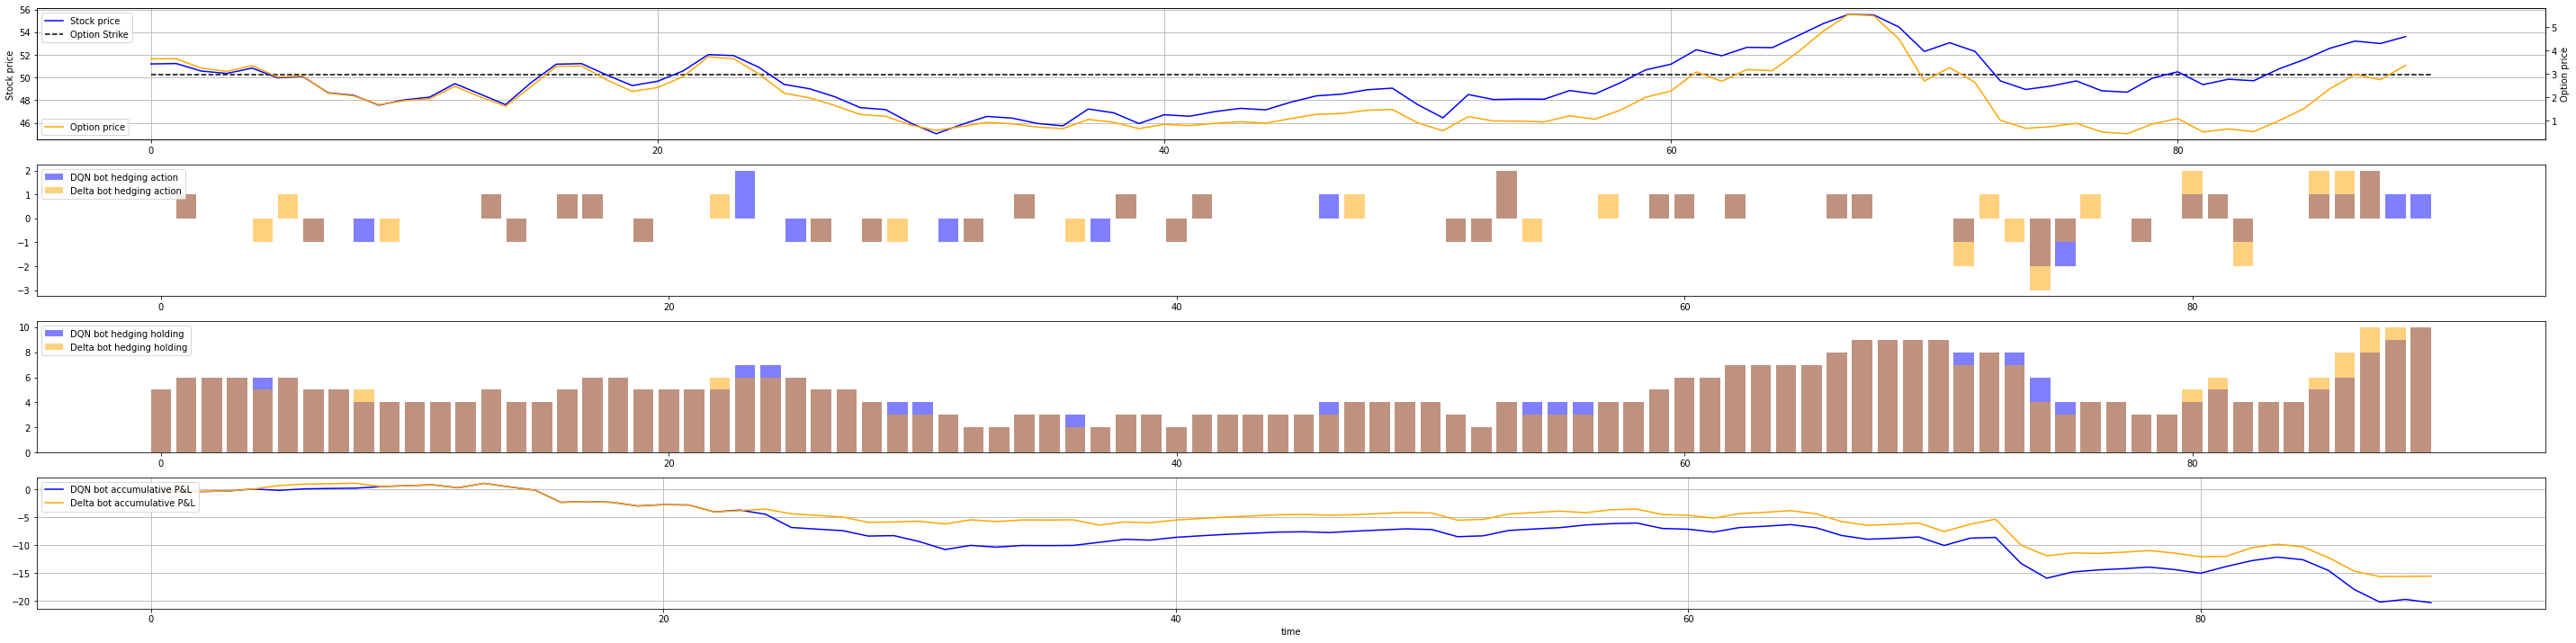

In [19]:
#@title One Path Prediction
pnl_order =  2#@param {type:"integer"}
path_num = dqn_index_order[pnl_order]
dqn_pnl_list = train_perf[train_perf.type=='pnl'].drop(['path_num','type'], axis=1).sum(axis=1)
delta_pnl_list = delta_hedge_perf[train_perf.type=='pnl'].drop(['path_num','type'], axis=1).sum(axis=1)

stock_price_path = train_perf[(train_perf.path_num==path_num)&(train_perf.type=='stock_price')].drop(['path_num','type'], axis=1)
option_price_path = delta_hedge_perf[(delta_hedge_perf.path_num==path_num)&(delta_hedge_perf.type=='option_price')].drop(['path_num','type'], axis=1)
dqn_action_path = train_perf[(train_perf.path_num==path_num)&(train_perf.type=='action')].drop(['path_num','type'], axis=1)
delta_action_path = delta_hedge_perf[(delta_hedge_perf.path_num==path_num)&(delta_hedge_perf.type=='action')].drop(['path_num','type'], axis=1)
dqn_cum_pnl_path = train_perf[(train_perf.path_num==path_num)&(train_perf.type=='pnl')].drop(['path_num','type'], axis=1)
delta_cum_pnl_path = delta_hedge_perf[(delta_hedge_perf.path_num==path_num)&(delta_hedge_perf.type=='pnl')].drop(['path_num','type'], axis=1)

stock_price_path.columns = stock_price_path.columns.astype(int) 
stock_price_path = pd.to_numeric(stock_price_path.reindex(sorted(stock_price_path.columns), axis=1).values[0])
option_price_path.columns = option_price_path.columns.astype(int) 
option_price_path = pd.to_numeric(option_price_path.reindex(sorted(option_price_path.columns), axis=1).values[0])
dqn_action_path.columns = dqn_action_path.columns.astype(int) 
dqn_action_path = pd.to_numeric(dqn_action_path.reindex(sorted(dqn_action_path.columns), axis=1).values[0])
delta_action_path.columns = delta_action_path.columns.astype(int) 
delta_action_path = pd.to_numeric(delta_action_path.reindex(sorted(delta_action_path.columns), axis=1).values[0])
dqn_cum_pnl_path.columns = dqn_cum_pnl_path.columns.astype(int) 
dqn_cum_pnl_path = np.cumsum(pd.to_numeric(dqn_cum_pnl_path.reindex(sorted(dqn_cum_pnl_path.columns), axis=1).values[0]))
delta_cum_pnl_path.columns = delta_cum_pnl_path.columns.astype(int) 
delta_cum_pnl_path = np.cumsum(pd.to_numeric(delta_cum_pnl_path.reindex(sorted(delta_cum_pnl_path.columns), axis=1).values[0]))
dqn_cum_holding_path = np.cumsum(dqn_action_path) + initial_stock_holding
delta_cum_holding_path = np.cumsum(delta_action_path) + initial_stock_holding

fig, axs = plt.subplots(4, 1,figsize=(40,10))
axs[0].plot(stock_price_path, label='Stock price', color='blue')
axs[0].grid(True)
axs[0].set_ylabel('Stock price')
axs[0].hlines(atm_strike, label='Option Strike', xmin=0, 
              xmax=len(stock_price_path), linestyles='dashed')
ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Option price') 
ax2.plot(option_price_path, label='Option price', color='orange')
axs[0].legend(loc='upper left')
ax2.legend(loc='lower left')

axs[1].bar(range(0, len(dqn_action_path)), dqn_action_path, color='blue', alpha=0.5, label='DQN bot hedging action')
axs[1].bar(range(0, len(delta_action_path)), delta_action_path, color='orange', alpha=0.5, label='Delta bot hedging action')
axs[1].legend(loc='upper left')

axs[2].bar(range(0, len(dqn_cum_holding_path)), dqn_cum_holding_path, color='blue', alpha=0.5, label='DQN bot hedging holding')
axs[2].bar(range(0, len(delta_cum_holding_path)), delta_cum_holding_path, color='orange', alpha=0.5, label='Delta bot hedging holding')
axs[2].legend(loc='upper left')

axs[3].plot(dqn_cum_pnl_path, color='blue', label='DQN bot accumulative P&L')
axs[3].plot(delta_cum_pnl_path, color='orange', label='Delta bot accumulative P&L')
axs[3].grid(True)
axs[3].legend(loc='upper left')
axs[3].set_xlabel('time')
fig.tight_layout()
plt.savefig(f'{model_path}price_action_prediction_sample{pnl_order}.png')
plt.show()

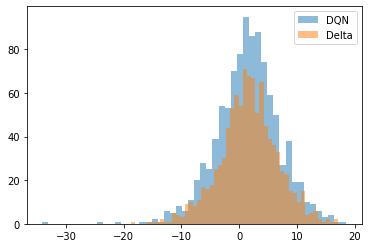

In [20]:
#@title P&L Distributions 
plt.hist(dqn_pnl_list, bins=50, alpha=0.5, label='DQN')
plt.hist(delta_pnl_list, bins=50, alpha=0.5, label='Delta')
plt.legend(loc='upper right')
plt.savefig(f'{model_path}dist.png')
plt.show()
np.save(f'{model_path}dqn_pred_pnl.npy',dqn_pnl_list)
np.save(f'{model_path}delta_pred_pnl.npy',delta_pnl_list)

In [15]:
print("DQN Bot PnL mean %s" % str(dqn_pnl_list.mean()))
print("DQN Bot PnL std %s" % str(dqn_pnl_list.std()))
print("Delta Bot PnL mean %s" % str(delta_pnl_list.mean()))
print("Delta Bot PnL std %s" % str(delta_pnl_list.std()))

DQN Bot PnL mean 1.4785869956542004
DQN Bot PnL std 5.49842177212004
Delta Bot PnL mean 1.5973144109096122
Delta Bot PnL std 5.017013048026552


In [27]:
train_progress = pd.read_csv(dqn_bot._predictor._progress_logger.file_path)
delta_bot._predictor._update_progress_figures()
delta_hedge_status = delta_bot._predictor._progress_measures

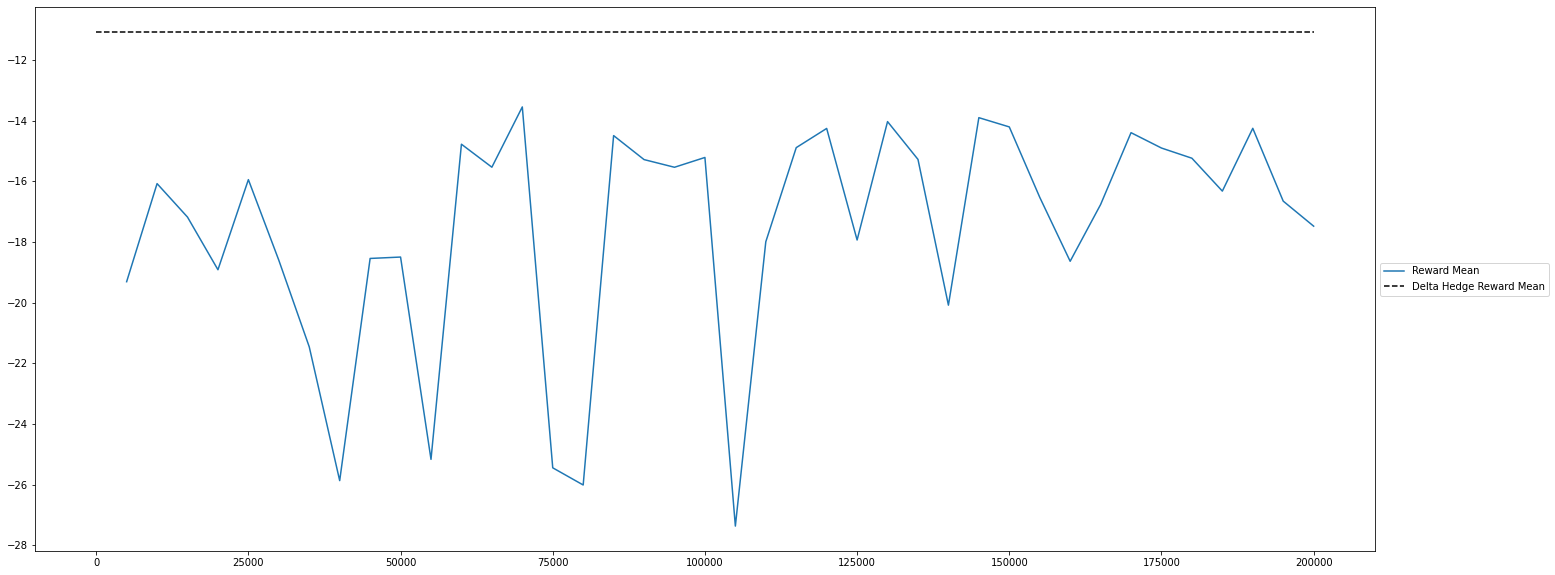

In [28]:
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(111)
ax.plot(train_progress['train_episodes'], train_progress['reward_mean'], label='Reward Mean')
ax.hlines(delta_hedge_status['reward_mean'], label='Delta Hedge Reward Mean', xmin=0, 
          xmax=train_progress['train_episodes'].max(), linestyles='dashed')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'{model_path}reward.png')
plt.show()

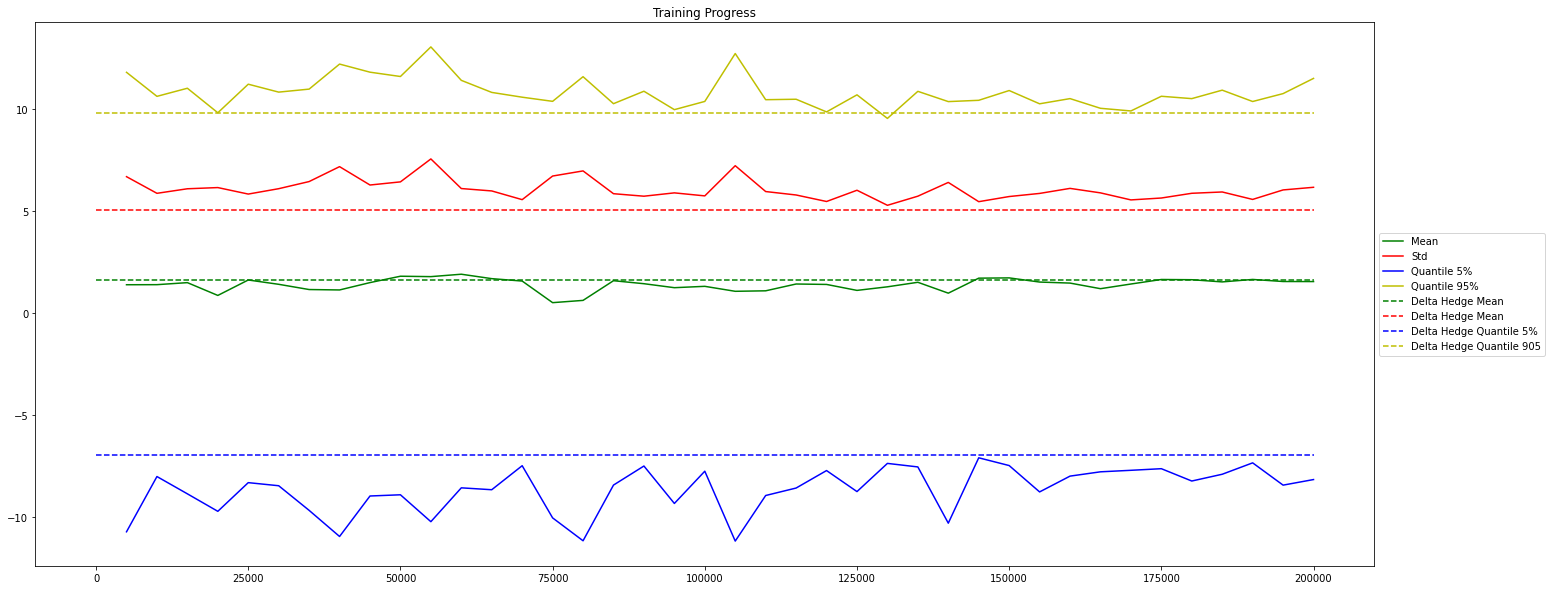

In [29]:
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(111)

pred_count = train_progress['train_episodes']
ax.plot(pred_count, train_progress['pnl_mean'], label='Mean', color='g')
ax.plot(pred_count, train_progress['pnl_std'], label='Std', color='r')
ax.plot(pred_count, train_progress['pnl_quantile_5'], label='Quantile 5%', color='b')
ax.plot(pred_count, train_progress['pnl_quantile_95'], label='Quantile 95%', color='y')
ax.hlines(delta_hedge_status['pnl_mean'], label='Delta Hedge Mean', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors='g')
ax.hlines(delta_hedge_status['pnl_std'], label='Delta Hedge Mean', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors='r')
ax.hlines(delta_hedge_status['pnl_quantile_5'], label='Delta Hedge Quantile 5%', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors='b')
ax.hlines(delta_hedge_status['pnl_quantile_95'], label='Delta Hedge Quantile 905', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors='y')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Training Progress')
plt.savefig(f'{model_path}quantiles.png')
plt.show()

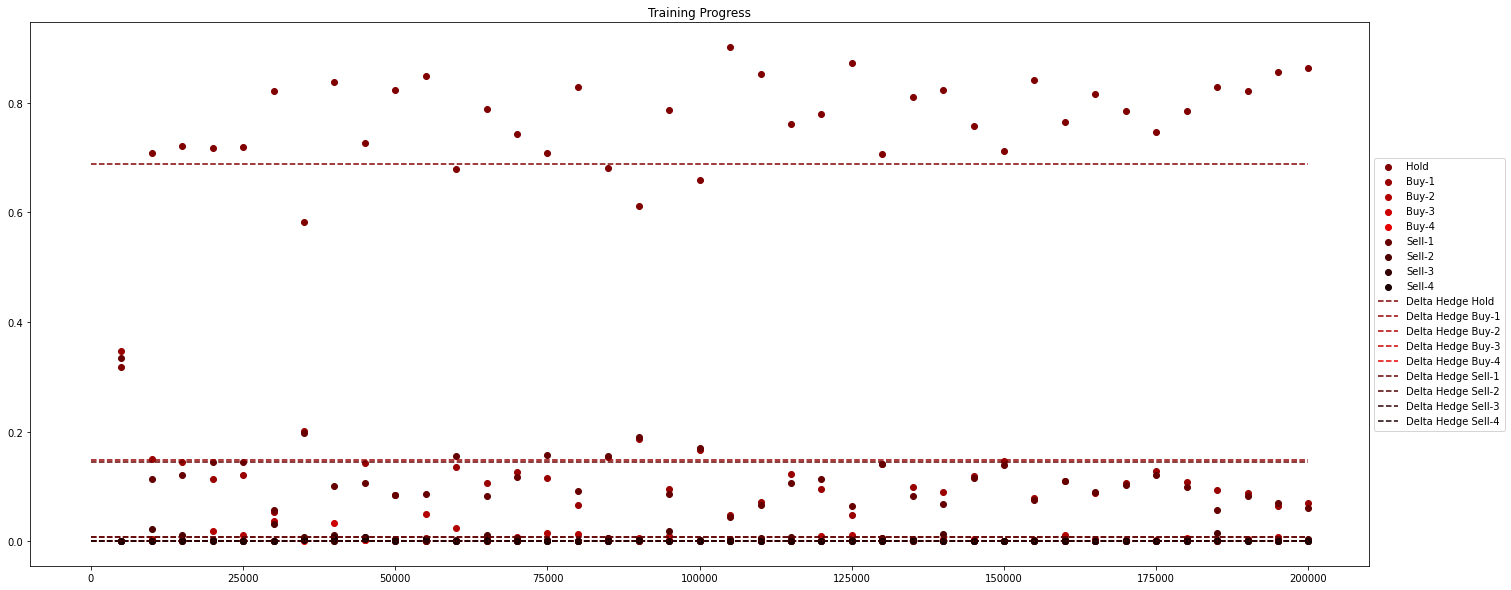

In [30]:
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(111)

pred_count = train_progress['train_episodes']
ax.scatter(pred_count, train_progress['hold'], label='Hold', color=(0.5,0,0))
ax.scatter(pred_count, train_progress['buy-1'], label='Buy-1', color=(0.6,0,0))
ax.scatter(pred_count, train_progress['buy-2'], label='Buy-2', color=(0.7,0,0))
ax.scatter(pred_count, train_progress['buy-3'], label='Buy-3', color=(0.8,0,0))
ax.scatter(pred_count, train_progress['buy-4'], label='Buy-4', color=(0.9,0,0))
ax.scatter(pred_count, train_progress['sell-1'], label='Sell-1', color=(0.4,0,0))
ax.scatter(pred_count, train_progress['sell-2'], label='Sell-2', color=(0.3,0,0))
ax.scatter(pred_count, train_progress['sell-3'], label='Sell-3', color=(0.2,0,0))
ax.scatter(pred_count, train_progress['sell-4'], label='Sell-4', color=(0.1,0,0))
ax.hlines(delta_hedge_status['hold'], label='Delta Hedge Hold', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.5,0,0))
ax.hlines(delta_hedge_status['buy-1'], label='Delta Hedge Buy-1', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.6,0,0))
ax.hlines(delta_hedge_status['buy-2'], label='Delta Hedge Buy-2', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.7,0,0))
ax.hlines(delta_hedge_status['buy-3'], label='Delta Hedge Buy-3', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.8,0,0))
ax.hlines(delta_hedge_status['buy-4'], label='Delta Hedge Buy-4', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.9,0,0))
ax.hlines(delta_hedge_status['sell-1'], label='Delta Hedge Sell-1', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.4,0,0))
ax.hlines(delta_hedge_status['sell-2'], label='Delta Hedge Sell-2', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.3,0,0))
ax.hlines(delta_hedge_status['sell-3'], label='Delta Hedge Sell-3', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.2,0,0))
ax.hlines(delta_hedge_status['sell-4'], label='Delta Hedge Sell-4', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.1,0,0))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Training Progress')
plt.show()

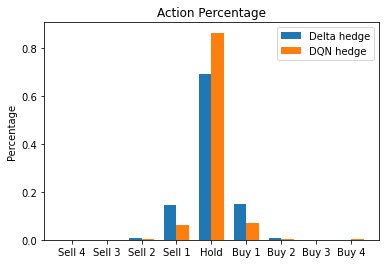

In [31]:
labels = ['Sell 4', 'Sell 3', 'Sell 2', 'Sell 1', 'Hold', 'Buy 1', 'Buy 2', 'Buy 3', 'Buy 4']
ind = ['sell-4','sell-3','sell-2','sell-1','hold', 'buy-1','buy-2','buy-3','buy-4']
delta_hedge_actions = np.array([delta_hedge_status[k] for k in ind])
qtable_hedge_actions = train_progress[['sell-4','sell-3','sell-2','sell-1','hold', 'buy-1','buy-2','buy-3','buy-4']].iloc[-1]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
deltah = ax.bar(x - width/2, delta_hedge_actions, width, label='Delta hedge')
qtableh = ax.bar(x + width/2, qtable_hedge_actions, width, label='DQN hedge')

ax.set_ylabel('Percentage')
ax.set_title('Action Percentage')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()
plt.savefig(f'{model_path}action.png')
plt.show()